In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_adbe = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/ADBE_Stock.csv"
df_adbe = pd.read_csv(csv_adbe, thousands=',')

In [3]:
df_adbe.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200


In [4]:
df_adbe.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,437.561171,437.561171,442.956797,431.746496,437.548852,2.987458e+06
std,112.802864,112.802864,113.786692,111.798628,112.881015,1.733830e+06
min,254.740005,254.740005,255.020004,249.100006,251.490005,5.892000e+05
25%,339.532501,339.532501,344.690010,333.492500,338.960007,2.039850e+06
50%,443.785004,443.785004,449.224991,436.915009,444.769989,2.573100e+06
75%,514.142502,514.142502,520.422485,508.869987,514.000000,3.413750e+06
max,688.369995,688.369995,699.539978,678.909973,696.280029,2.784020e+07


In [5]:
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_adbe['Date'] = df_adbe['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_adbe = df_adbe.sort_values(by="Date").reset_index(drop=True)
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_adbe.Close

0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_adbe.iterrows(), total=df_adbe.shape[0]):
    row_data = dict(
        day = row.Date.day,
        month = row.Date.month,
        year = row.Date.year,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume,
    )
    rows.append(row_data)
features_adbe = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_adbe.head()

,day,month,year,open,low,high,close,volume
0,1,3,2019,265.750000,264.010010,266.239990,264.010010,2594000
1,4,3,2019,266.700012,258.160004,267.000000,258.160004,2994900
2,5,3,2019,259.000000,257.380005,259.869995,257.380005,2101800
3,6,3,2019,257.399994,256.399994,259.489990,256.399994,1950500
4,7,3,2019,255.770004,255.460007,257.489990,255.460007,3185200


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_adbe, 'close')

Empty DataFrame
Columns: [day, month, year, open, low, high, close, volume]
Index: []


In [12]:
train_size = int(0.75 * len(features_adbe))
test_size = len(features_adbe)-train_size

train_adbe_df = features_adbe[:train_size]
test_adbe_df = features_adbe[train_size:]

In [13]:
#Quá trình Training
x_train = np.array(train_adbe_df.index).reshape(-1, 1)
y_train = np.array(train_adbe_df['close'])
# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)
# In các thông số của mô hình
print("Hệ số hồi quy (slope):", model.coef_)
print("Sai số chệch (intercept):", model.intercept_)

Hệ số hồi quy (slope): [0.16103306]
Sai số chệch (intercept): 338.3961830767822


In [14]:
#Quá trình testing
x_test = np.array(test_adbe_df.index).reshape(-1, 1)
y_test = np.array(test_adbe_df['close'])
y_pred = model.predict(x_test)

In [15]:
#Quá trình tạo index predict 30 ngày tiếp theo
last_index = features_adbe.index[-1]
last_30_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[551.60395387 551.76498693 551.92601999 552.08705305 552.24808611
 552.40911917 552.57015223 552.73118529 552.89221835 553.05325141
 553.21428447 553.37531753 553.53635059 553.69738365 553.85841671
 554.01944977 554.18048283 554.34151589 554.50254895 554.66358201
 554.82461506 554.98564812 555.14668118 555.30771424 555.4687473
 555.62978036 555.79081342 555.95184648 556.11287954 556.2739126 ]


In [16]:
#Quá trình tạo index predict 60 ngày tiếp theo
last_index = features_adbe.index[-1]
last_60_data = pd.RangeIndex(start=last_index, stop=last_index+60, step=1)

# Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index+1, last_index+61)).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(x_next_60_days)

# Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)

Predicted closing prices for the next 60 days:
[551.60395387 551.76498693 551.92601999 552.08705305 552.24808611
 552.40911917 552.57015223 552.73118529 552.89221835 553.05325141
 553.21428447 553.37531753 553.53635059 553.69738365 553.85841671
 554.01944977 554.18048283 554.34151589 554.50254895 554.66358201
 554.82461506 554.98564812 555.14668118 555.30771424 555.4687473
 555.62978036 555.79081342 555.95184648 556.11287954 556.2739126
 556.43494566 556.59597872 556.75701178 556.91804484 557.0790779
 557.24011096 557.40114402 557.56217708 557.72321014 557.8842432
 558.04527625 558.20630931 558.36734237 558.52837543 558.68940849
 558.85044155 559.01147461 559.17250767 559.33354073 559.49457379
 559.65560685 559.81663991 559.97767297 560.13870603 560.29973909
 560.46077215 560.62180521 560.78283827 560.94387133 561.10490439]


In [17]:
#Quá trình tạo index predict 90 ngày tiếp theo
last_index = features_adbe.index[-1]
last_90_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_90_days = model.predict(x_next_90_days)

# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[551.60395387 551.76498693 551.92601999 552.08705305 552.24808611
 552.40911917 552.57015223 552.73118529 552.89221835 553.05325141
 553.21428447 553.37531753 553.53635059 553.69738365 553.85841671
 554.01944977 554.18048283 554.34151589 554.50254895 554.66358201
 554.82461506 554.98564812 555.14668118 555.30771424 555.4687473
 555.62978036 555.79081342 555.95184648 556.11287954 556.2739126
 556.43494566 556.59597872 556.75701178 556.91804484 557.0790779
 557.24011096 557.40114402 557.56217708 557.72321014 557.8842432
 558.04527625 558.20630931 558.36734237 558.52837543 558.68940849
 558.85044155 559.01147461 559.17250767 559.33354073 559.49457379
 559.65560685 559.81663991 559.97767297 560.13870603 560.29973909
 560.46077215 560.62180521 560.78283827 560.94387133 561.10490439
 561.26593745 561.4269705  561.58800356 561.74903662 561.91006968
 562.07110274 562.2321358  562.39316886 562.55420192 562.71523498
 562.87626804 563.0373011  563.19

In [18]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 83.15278489475058
Testing MAE: 66.50910551692083
Testing MAPE: 0.15501207728842964


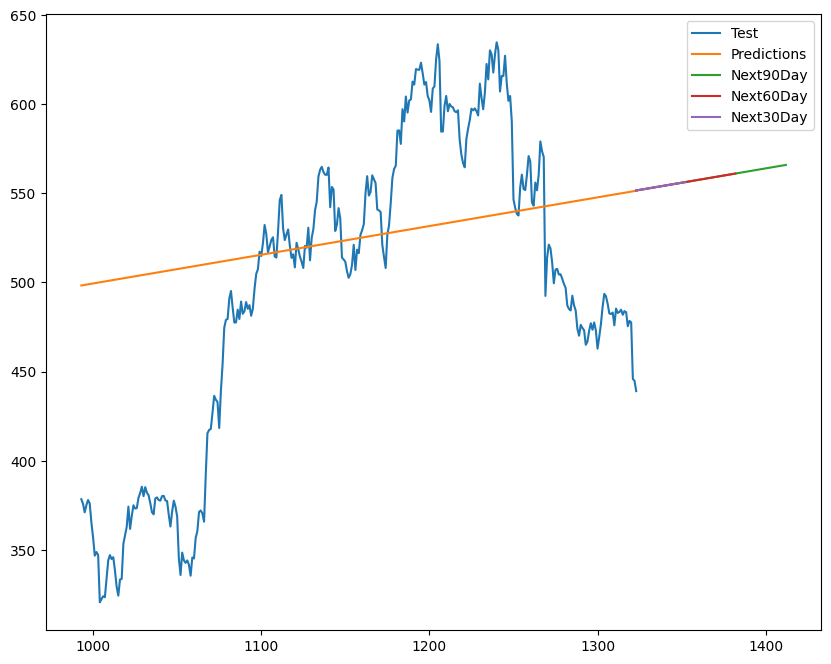

In [19]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(test_adbe_df.index, test_adbe_df['close'])
plt.plot(test_adbe_df.index, y_pred)
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Test', 'Predictions','Next90Day','Next60Day','Next30Day'])
plt.show()

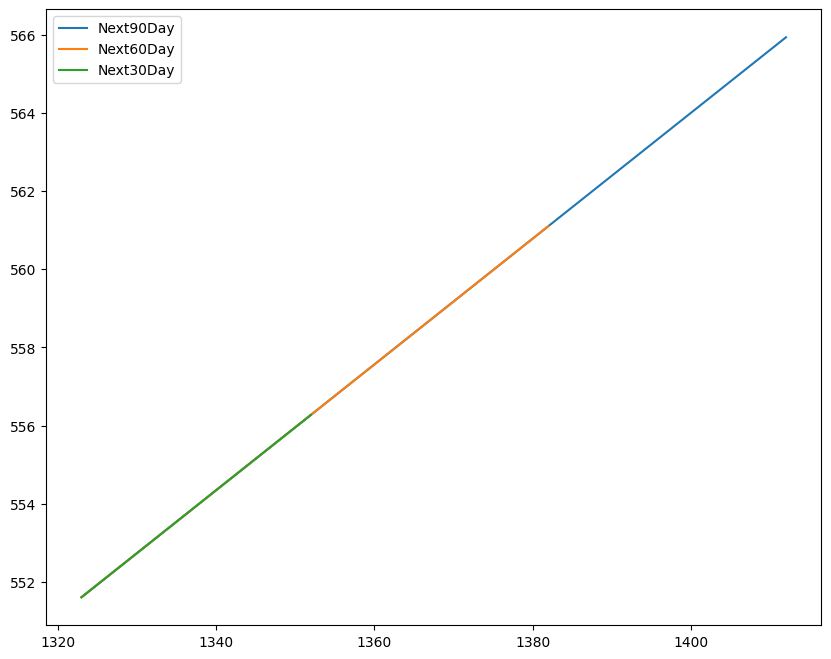

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Next90Day','Next60Day','Next30Day'])
plt.show()